# Ocean warming : a historical perspective using Ocean Heat Content calculations


In [ ]:
# Necessary to run in Google Collab
!pip install --upgrade dask distributed xarray zarr gcsfs cftime nc-time-axis intake intake-xarray

     |████████████████████████████████| 890kB 8.1MB/s 
     |████████████████████████████████| 675kB 14.7MB/s 
     |████████████████████████████████| 737kB 13.5MB/s 
     |████████████████████████████████| 133kB 28.8MB/s 
     |████████████████████████████████| 327kB 27.0MB/s 
     |████████████████████████████████| 1.5MB 31.8MB/s 
     |████████████████████████████████| 1.9MB 41.7MB/s 
     |████████████████████████████████| 5.8MB 19.4MB/s 
     |████████████████████████████████| 1.3MB 36.9MB/s 
     |████████████████████████████████| 102kB 3.4MB/s 
     |████████████████████████████████| 4.7MB 29.9MB/s 
     |████████████████████████████████| 102kB 9.2MB/s 
     |████████████████████████████████| 296kB 45.1MB/s 
     |████████████████████████████████| 143kB 33.5MB/s 
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7667 sha256=5be476921cc9d3e4dce0edfe3c0fbb6dc971a12f461982f651bcf6ea8c3d5f0c
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae

In [ ]:
import xarray as xr
from intake import open_catalog
import matplotlib.pyplot as plt

## Accessing the data

In [ ]:
catalog_url = 'https://raw.githubusercontent.com/obidam/ds2-2021/main/ds2_data_catalog.yml'
cat = open_catalog(catalog_url)
list(cat)

['argo_global_sdl',
 'argo_global_homogeneous_sdl',
 'en4',
 'isas15_temp_natl',
 'argo_global_vertical_mean',
 'sea_surface_height']

In [ ]:
ds = cat["en4"].to_dask()
print("Size of the dataset:", ds.nbytes/1e9,"Gb")
ds

Size of the dataset: 52.2317975 Gb


<xarray.Dataset>
Dimensions:                          (bnds: 2, depth: 42, lat: 173, lon: 360, time: 832)
Coordinates:
  * depth                            (depth) float32 5.022 15.08 ... 5.35e+03
  * lat                              (lat) float32 -83.0 -82.0 ... 88.0 89.0
  * lon                              (lon) float32 1.0 2.0 3.0 ... 359.0 360.0
  * time                             (time) datetime64[ns] 1950-01-16T12:00:0...
Dimensions without coordinates: bnds
Data variables:
    depth_bnds                       (time, depth, bnds) float32 dask.array<chunksize=(1, 42, 2), meta=np.ndarray>
    salinity                         (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    salinity_observation_weights     (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    salinity_uncertainty             (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    temperature                      (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    temperature_observation_weights  (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    temperature_uncertainty          (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    time_bnds                        (time, bnds) datetime64[ns] dask.array<chunksize=(832, 2), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.0
    DSD_entry_id:           UKMO-L4UHFnd-GLOB-v01
    GDS_version_id:         v1.7
    contact:                Simon Good - simon.good@metoffice.gov.uk
    creation_date:          2017-04-21 21:12:08.123 -00:00
    easternmost_longitude:  362.5
    file_quality_index:     0
    grid_resolution:           1.00000 degree
    history:                
    institution:            UK Met Office
    netcdf_version_id:      3.5
    northernmost_latitude:  89.5
    product_version:        1.0
    references:             None
    southernmost_latitude:  -90.5
    start_date:             2001-01-01 UTC
    start_time:             00:00:00 UTC
    stop_date:              2001-01-01 UTC
    stop_time:              00:00:00 UTC
    title:                  Temperature and salinity analysis
    westernmost_longitude:  0.5

(array([200574., 551250., 184587., 121446., 117685., 101787.,  86067.,
         69770.,  61680.,  49973.]),
 array([269.6604 , 273.05392, 276.44745, 279.84094, 283.23447, 286.628  ,
        290.0215 , 293.41504, 296.80853, 300.20206, 303.59558],
       dtype=float32),
 <a list of 10 Patch objects>)

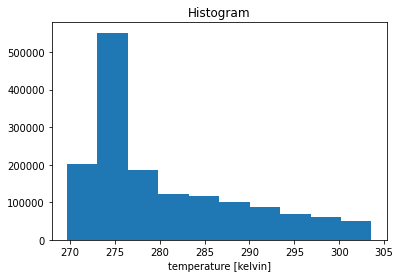

In [ ]:
# Simple plot to check the dataset
ds['temperature'].isel(time=555, ).plot()

## Ocean Heat Content (OHC)

In [ ]:
from scipy.integrate import quad
import numpy as np
import pandas as pd
import math
import time
from scipy.spatial import cKDTree

In [ ]:
rho = 1030
cp = 3930
# Écart entre la profondeurr des différents points
ecartH =np.diff(ds['depth'].values)
ecartH

array([ 10.05695 ,  10.08192 ,  10.11783 ,  10.169472,  10.243732,
        10.350491,  10.503929,  10.724373,  11.040894,  11.494995,
        12.145721,  13.076653,  14.405182,  16.294724,  18.96901 ,
        22.727982,  27.960724,  35.14795 ,  44.839966,  57.59137 ,
        73.83548 ,  93.70126 , 116.82074 , 142.22668 , 168.44623 ,
       193.81006 , 216.8551  , 236.62952 , 252.78015 , 265.4464  ,
       275.0664  , 282.19678 , 287.38574 , 291.11206 , 293.7627  ,
       295.6355  , 296.95166 , 297.87402 , 298.51904 , 298.96875 ,
       299.28223 ], dtype=float32)

In [ ]:
def compute_ohc(ds) : 
  ohc = np.zeros((832,173,360))
  for i in range (832):
    a =ds['temperature'][i,:-1,:,:].values
    b =ds['temperature'][i,1:,:,:].values
    T_moy = (a+b)/2   
    OHCi = np.nansum(T_moy * ecartH[:,None,None] * cp * rho, axis=0)
    ohc[i,:,:] = OHCi
  return (ohc)

In [ ]:
ohc = compute_ohc(ds)

In [ ]:
# Dimension is (time, latitude, longitude)
np.shape(ohc)

(832, 173, 360)

In [ ]:
ds['ohc'] = xr.DataArray(ohc,dims =('time','lat','lon'), coords = {'time' : ds['time'], 'lon' : ds['lon'], 'lat' : ds['lat']})
ds

<xarray.Dataset>
Dimensions:                          (bnds: 2, depth: 42, lat: 173, lon: 360, time: 832)
Coordinates:
  * depth                            (depth) float32 5.022 15.08 ... 5.35e+03
  * lat                              (lat) float32 -83.0 -82.0 ... 88.0 89.0
  * lon                              (lon) float32 1.0 2.0 3.0 ... 359.0 360.0
  * time                             (time) datetime64[ns] 1950-01-16T12:00:0...
Dimensions without coordinates: bnds
Data variables:
    depth_bnds                       (time, depth, bnds) float32 dask.array<chunksize=(1, 42, 2), meta=np.ndarray>
    salinity                         (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    salinity_observation_weights     (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    salinity_uncertainty             (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    temperature                      (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    temperature_observation_weights  (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    temperature_uncertainty          (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    time_bnds                        (time, bnds) datetime64[ns] dask.array<chunksize=(832, 2), meta=np.ndarray>
    ohc                              (time, lat, lon) float64 0.0 ... 4.582e+12
Attributes:
    Conventions:            CF-1.0
    DSD_entry_id:           UKMO-L4UHFnd-GLOB-v01
    GDS_version_id:         v1.7
    contact:                Simon Good - simon.good@metoffice.gov.uk
    creation_date:          2017-04-21 21:12:08.123 -00:00
    easternmost_longitude:  362.5
    file_quality_index:     0
    grid_resolution:           1.00000 degree
    history:                
    institution:            UK Met Office
    netcdf_version_id:      3.5
    northernmost_latitude:  89.5
    product_version:        1.0
    references:             None
    southernmost_latitude:  -90.5
    start_date:             2001-01-01 UTC
    start_time:             00:00:00 UTC
    stop_date:              2001-01-01 UTC
    stop_time:              00:00:00 UTC
    title:                  Temperature and salinity analysis
    westernmost_longitude:  0.5

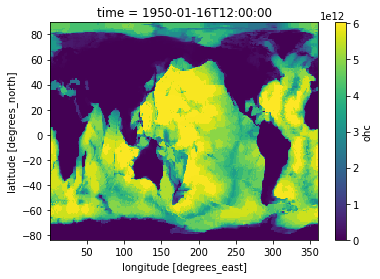

In [ ]:
# Affichage de la répartition spatiale de l'OHC au temps d'indice 0
ds['ohc'].isel(time=0).plot()

##OHC à 700m de profondeur

In [ ]:
# 24 est l'indice qui correspond à 700m de profondeur
ecartH700 = ecartH[:24]

In [ ]:
a =ds['temperature'][0,:-1,:,:].values
b =ds['temperature'][0,1:,:,:].values
T_moy = (a+b)/2

# Calcul de l'OHC 700M
OHC700 = np.nansum(T_moy[:24,:,:] * ecartH700[:,None,None] * cp * rho, axis=0)
OHC700

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [8.7838910e+11, 8.7840791e+11, 8.7842842e+11, ..., 8.7832841e+11,
        8.7834460e+11, 8.7836485e+11],
       [8.7831406e+11, 8.7831465e+11, 8.7831858e+11, ..., 8.7829748e+11,
        8.7830187e+11, 8.7830725e+11],
       [8.7829486e+11, 8.7829886e+11, 8.7830430e+11, ..., 8.7827402e+11,
        8.7827880e+11, 8.7828922e+11]], dtype=float32)

In [ ]:
def get_ohc_at_700m(ds) : 
  ohc = np.zeros((832,173,360))
  for i in range (832):
    a =ds['temperature'][i,:-1,:,:].values
    b =ds['temperature'][i,1:,:,:].values
    T_moy = (a+b)/2   
    OHCi = np.nansum(T_moy[:24,:,:] * ecartH700[:,None,None] * cp * rho, axis=0)
    ohc[i,:,:] = OHCi
  return (ohc)

In [ ]:
ohc700 = get_ohc_at_700m(ds)
print(ohc700)

[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  ...
  [8.78389101e+11 8.78407909e+11 8.78428422e+11 ... 8.78328414e+11
   8.78344602e+11 8.78364852e+11]
  [8.78314062e+11 8.78314652e+11 8.78318584e+11 ... 8.78297481e+11
   8.78301872e+11 8.78307246e+11]
  [8.78294860e+11 8.78298857e+11 8.78304297e+11 ... 8.78274019e+11
   8.78278803e+11 8.78289224e+11]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  ...
  [8.78211891e+11 8.78222246e+11 8.78238433e+11 ... 8.78159856e+11
   8.78174

In [ ]:
OHC700 = xr.DataArray(ohc700,dims =('time','lat','lon'), coords = {'time' : ds['time'], 'lon' : ds['lon'], 'lat' : ds['lat']})
ds['ohc700'] = OHC700
ds

<xarray.Dataset>
Dimensions:                          (bnds: 2, depth: 42, lat: 173, lon: 360, time: 832)
Coordinates:
  * depth                            (depth) float32 5.022 15.08 ... 5.35e+03
  * lat                              (lat) float32 -83.0 -82.0 ... 88.0 89.0
  * lon                              (lon) float32 1.0 2.0 3.0 ... 359.0 360.0
  * time                             (time) datetime64[ns] 1950-01-16T12:00:0...
Dimensions without coordinates: bnds
Data variables:
    depth_bnds                       (time, depth, bnds) float32 dask.array<chunksize=(1, 42, 2), meta=np.ndarray>
    salinity                         (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    salinity_observation_weights     (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    salinity_uncertainty             (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    temperature                      (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    temperature_observation_weights  (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    temperature_uncertainty          (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    time_bnds                        (time, bnds) datetime64[ns] dask.array<chunksize=(832, 2), meta=np.ndarray>
    ohc                              (time, lat, lon) float64 0.0 ... 4.582e+12
    ohc700                           (time, lat, lon) float64 0.0 ... 8.792e+11
Attributes:
    Conventions:            CF-1.0
    DSD_entry_id:           UKMO-L4UHFnd-GLOB-v01
    GDS_version_id:         v1.7
    contact:                Simon Good - simon.good@metoffice.gov.uk
    creation_date:          2017-04-21 21:12:08.123 -00:00
    easternmost_longitude:  362.5
    file_quality_index:     0
    grid_resolution:           1.00000 degree
    history:                
    institution:            UK Met Office
    netcdf_version_id:      3.5
    northernmost_latitude:  89.5
    product_version:        1.0
    references:             None
    southernmost_latitude:  -90.5
    start_date:             2001-01-01 UTC
    start_time:             00:00:00 UTC
    stop_date:              2001-01-01 UTC
    stop_time:              00:00:00 UTC
    title:                  Temperature and salinity analysis
    westernmost_longitude:  0.5

In [ ]:
ds['ohc700J'] = ds['ohc700']*510065700000000 ## Conversion en Joules



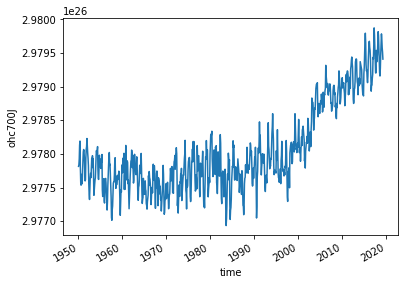

In [ ]:
ohc700mean = ds['ohc700J'].mean(dim='lat').mean(dim='lon')
ohc700mean.plot()

##incertitudes 


In [ ]:
def compute_ohc_uncertainty(ds) : 
  ohc = np.zeros((832,173,360))
  for i in range (832):
    a =ds['temperature_uncertainty'][i,:-1,:,:].values
    b =ds['temperature_uncertainty'][i,1:,:,:].values
    T_moy = (a+b)/2   
    OHCi = np.nansum(T_moy * ecartH[:,None,None] * cp * rho, axis=0)
    ohc[i,:,:] = OHCi
  return (ohc)

In [ ]:
ohc_mean = ds['ohc'].sel(time=slice('1970','2019')).mean()
print(ohc_mean)
ohc_mean_700 = ds['ohc700'].sel(time=slice('1970','2019')).mean()

<xarray.DataArray 'ohc' ()>
array(2.88228863e+12)


In [ ]:
ohc_uncertainty = compute_ohc_uncertainty(ds)
ohc_uncertainty_700 = compute_ohc_uncertainty_700m(ds)

In [ ]:
def compute_ohc_uncertainty_700m(ds) : 
  ohc = np.zeros((832,173,360))
  for i in range (832):
    a =ds['temperature_uncertainty'][i,:-1,:,:].values
    b =ds['temperature_uncertainty'][i,1:,:,:].values
    T_moy = (a+b)/2   
    OHCi = np.nansum(T_moy[:24,:,:] * ecartH[:24,None,None] * cp * rho, axis=0)
    ohc[i,:,:] = OHCi
  return (ohc)

In [ ]:
OHCUN = xr.DataArray(ohc_uncertainty,dims =('time','lat','lon'), coords = {'time' : ds['time'], 'lon' : ds['lon'], 'lat' : ds['lat']})
OHCUN700 = xr.DataArray(ohc_uncertainty_700,dims =('time','lat','lon'), coords = {'time' : ds['time'], 'lon' : ds['lon'], 'lat' : ds['lat']})
ds['ohc_uncertainty'] = OHCUN
ds['ohc_uncertainty_700'] = OHCUN700
ds['ohc_uncertainty_700']

<xarray.DataArray 'ohc_uncertainty_700' (time: 832, lat: 173, lon: 360)>
array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [1.52254490e+09, 1.50592192e+09, 1.50978458e+09, ...,
         1.34657882e+09, 1.35350554e+09, 1.41378790e+09],
        [1.15400717e+09, 1.26314906e+09, 1.31508544e+09, ...,
         1.14476416e+09, 1.09466150e+09, 1.09907046e+09],
        [9.32585216e+08, 8.52744064e+08, 9.20904064e+08, ...,
         9.97149376e+08, 9.48134272e+08, 9.43284160e+08]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
...
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]])
Coordinates:
  * lat      (lat) float32 -83.0 -82.0 -81.0 -80.0 -79.0 ... 86.0 87.0 88.0 89.0
  * lon      (lon) float32 1.0 2.0 3.0 4.0 5.0 ... 356.0 357.0 358.0 359.0 360.0
  * time     (time) datetime64[ns] 1950-01-16T12:00:00 1950-02-15 ... 2019-04-16

In [ ]:
mean_uncertainty= (rho*cp*np.sqrt(24*173*360)*4*5e11)/(5.10e14)
mean_uncertainty

19407496.541865792

In [ ]:
t = np.array(ds['time'].sel(time=slice('1970','2019')).groupby('time.year').mean(dim='time'))

y700=np.array((ds['ohc700']-ohc_mean_700).sel(time=slice('1970','2019')).groupby('time.year').mean(dim='time').mean(dim='lat').mean(dim='lon'))
y700
y=np.array((ds['ohc']-ohc_mean).sel(time=slice('1970','2019')).groupby('time.year').mean(dim='time').mean(dim='lat').mean(dim='lon'))

yun_down = np.array(((ds['ohc']-ds['ohc_uncertainty']/2)-ohc_mean).sel(time=slice('1970','2019')).groupby('time.year').mean(dim='time').mean(dim='lat').mean(dim='lon'))
yun_up = np.array(((ds['ohc']+ds['ohc_uncertainty']/2)-ohc_mean).sel(time=slice('1970','2019')).groupby('time.year').mean(dim='time').mean(dim='lat').mean(dim='lon'))

ym_up = np.array(((ds['ohc']+mean_uncertainty)-ohc_mean).sel(time=slice('1970','2019')).groupby('time.year').mean(dim='time').mean(dim='lat').mean(dim='lon'))
ym_down =  np.array(((ds['ohc']-mean_uncertainty)-ohc_mean).sel(time=slice('1970','2019')).groupby('time.year').mean(dim='time').mean(dim='lat').mean(dim='lon'))

y700m_up = np.array(((ds['ohc700']+mean_uncertainty)-ohc_mean_700).sel(time=slice('1970','2019')).groupby('time.year').mean(dim='time').mean(dim='lat').mean(dim='lon'))
y700m_down =  np.array(((ds['ohc700']-mean_uncertainty)-ohc_mean_700).sel(time=slice('1970','2019')).groupby('time.year').mean(dim='time').mean(dim='lat').mean(dim='lon'))

y700un_down = np.array(((ds['ohc700']-ds['ohc_uncertainty_700']/2)-ohc_mean_700).sel(time=slice('1970','2019')).groupby('time.year').mean(dim='time').mean(dim='lat').mean(dim='lon'))
y700un_up = np.array(((ds['ohc700']+ds['ohc_uncertainty_700']/2)-ohc_mean_700).sel(time=slice('1970','2019')).groupby('time.year').mean(dim='time').mean(dim='lat').mean(dim='lon'))


array([-5.63102043e+08, -5.05210364e+08, -5.22046323e+08, -5.32541307e+08,
       -5.12425963e+08, -5.03652301e+08, -4.93693547e+08, -4.90348687e+08,
       -5.19430176e+08, -4.87014338e+08, -4.36487464e+08, -4.83063590e+08,
       -4.92683703e+08, -5.46594008e+08, -5.28979878e+08, -4.71678622e+08,
       -4.99786362e+08, -5.37111542e+08, -4.68179463e+08, -4.70170418e+08,
       -4.83140559e+08, -4.29031357e+08, -4.90584489e+08, -4.25477890e+08,
       -4.27873929e+08, -4.61689725e+08, -4.68166495e+08, -4.75651727e+08,
       -4.27441124e+08, -3.93176280e+08, -3.96136005e+08, -4.04461602e+08,
       -3.81475861e+08, -2.93658855e+08, -2.50335237e+08, -2.38435291e+08,
       -1.89314584e+08, -2.19139514e+08, -2.24594734e+08, -1.87922776e+08,
       -1.85671448e+08, -1.68124617e+08, -1.63576214e+08, -1.48638091e+08,
       -1.58695339e+08, -1.08796026e+08, -1.18778654e+08, -9.01296165e+07,
       -8.25047584e+07,  2.59301974e+08])

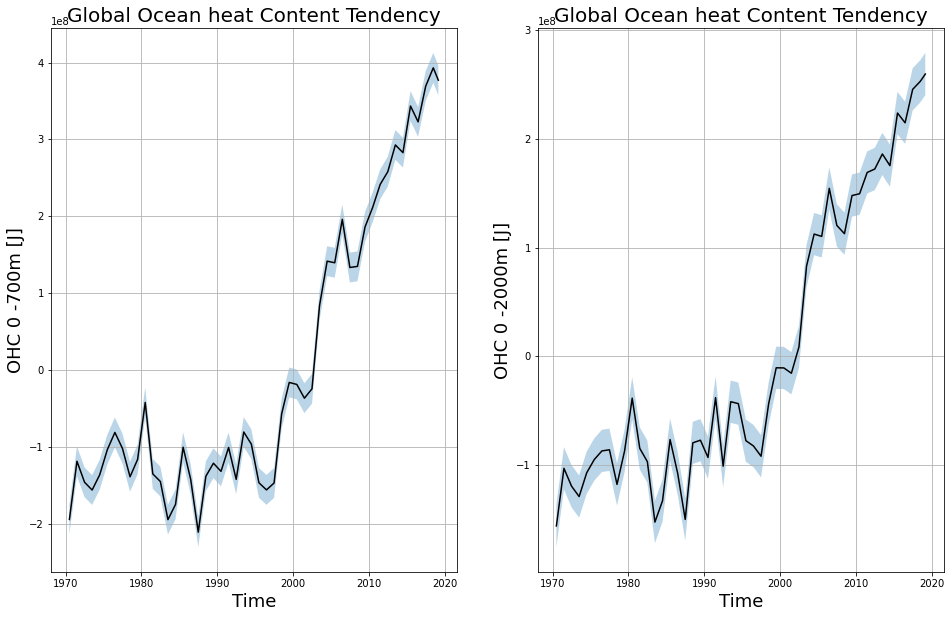

In [ ]:
plt.figure(figsize=(16,10))

plt.subplot(1,2,1)
plt.plot(t,y,'k')
plt.fill_between(t, ym_down, ym_up, alpha=0.3)
plt.title('Global Ocean heat Content Tendency',fontsize=20)
plt.ylabel('OHC 0 -700m [J]', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.grid()

plt.subplot(1,2,2)
plt.plot(t,y700,'k')
plt.fill_between(t, y700m_down, y700m_up, alpha=0.3)
plt.title('Global Ocean heat Content Tendency',fontsize=20)
plt.ylabel('OHC 0 -2000m [J]', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.grid()


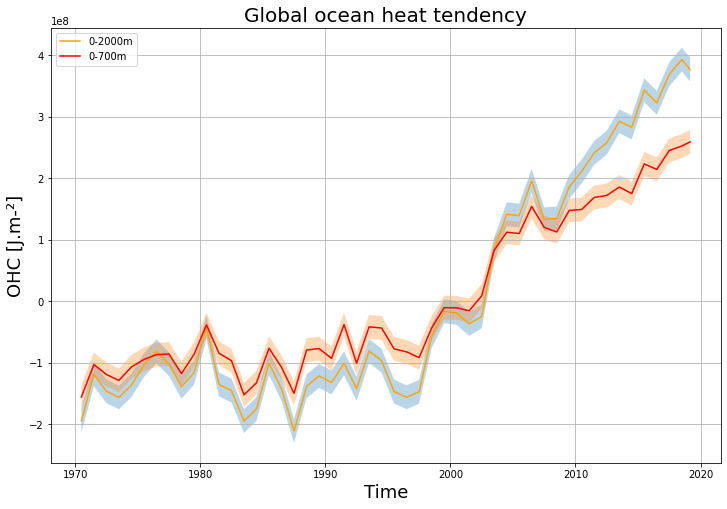

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(t,y,'orange',label='0-2000m')
plt.fill_between(t, ym_down, ym_up, alpha=0.3)
plt.plot(t,y700,'red',label='0-700m')
plt.fill_between(t, y700m_down, y700m_up, alpha=0.3)
plt.title('Global ocean heat tendency', fontsize=20)
plt.ylabel('OHC [J.m-²]', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.legend()
plt.grid()

In [ ]:
def haversine (lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    # harversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat/2.)**2. + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2.)**2.
    c = 2. * math.asin(math.sqrt(a))
    km = 6371. * c # radius of earth
    return km


In [ ]:
#tentative de partitionage des aires des differentes zones de la terre 
dx = np.zeros(len(ds['lon'])-1)
for i in range(len(ds['lat'])):
   dx[i] = haversine(ds['lon'][0], ds['lat'][i], ds['lon'][1], ds['lat'][i])

dy = np.zeros(len(ds['lat'])-1)
for i in range(len(ds['lat'])-1):
   dy[i] = haversine(0, ds['lat'][i], 0, ds['lat'][i+1])

xx,yy = np.meshgrid(dx,dy)
surface = xx*yy
np.shape(surface)
len(surface)

172

In [ ]:
# copy from top to bottom
surfacec = surface.copy
for i in range (172):
  for j in range (180) : 
    surface[i][358-j] = surface[i][j]
surface

array([[1506.81170876, 1720.75818442, 1934.18053934, ..., 1934.18053934,
        1720.75818442, 1506.81170876],
       [1506.81170876, 1720.75818442, 1934.18053934, ..., 1934.18053934,
        1720.75818442, 1506.81170876],
       [1506.81170876, 1720.75818442, 1934.18053934, ..., 1934.18053934,
        1720.75818442, 1506.81170876],
       ...,
       [1506.81170876, 1720.75818442, 1934.18053934, ..., 1934.18053934,
        1720.75818442, 1506.81170876],
       [1506.81170876, 1720.75818442, 1934.18053934, ..., 1934.18053934,
        1720.75818442, 1506.81170876],
       [1506.81170876, 1720.75818442, 1934.18053934, ..., 1934.18053934,
        1720.75818442, 1506.81170876]])

In [ ]:
t = np.array(ds['time'].sel(time=slice('1970','2019')).groupby('time.year').mean(dim='time'))
y=np.array((ds['ohc700']).sel(time=slice('1970','2019')).groupby('time.year').mean(dim='time').mean(dim='lat').mean(dim='lon'))
uncertainty = np.array(OHCun[-50:].mean(axis=(1,2)) / 2)


## Modélisation et prédiction

In [ ]:
from scipy.stats.mstats import zscore
import warnings
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.linear_model import LinearRegression

In [ ]:
t_julian = pd.to_datetime(pd.to_datetime(t)).to_julian_date()
t2 = np.arange('2020-01', '2100-12', dtype='datetime64[D]')
t_tot = np.concatenate([t, t2])
t2_julian = pd.to_datetime(pd.to_datetime(t2)).to_julian_date()
t_tot_julian = np.concatenate([t_julian, t2_julian])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  This is separate from the ipykernel package so we can avoid doing imports until


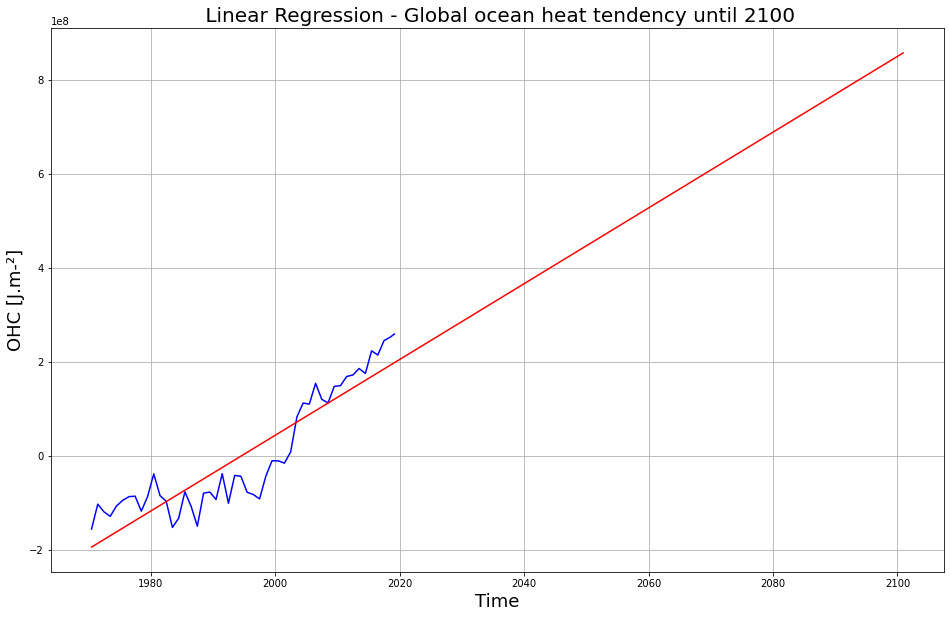

In [ ]:
model = LinearRegression()

model.fit(t_julian[:,None], y700[:,None])

y_hat = model.predict(t_tot_julian[:,None])

fig=plt.figure(figsize=(16,10))

plt.plot(t,y700,'b')
plt.plot(t_tot,y_hat,'r')
plt.title(' Linear Regression - Global ocean heat tendency until 2100', fontsize=20)
plt.ylabel('OHC [J.m-²]', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.grid()

In [ ]:
# Créer un dataframe pour contenir les informations pertinentes : les dates et l'OHC correspondant à la date

# Copie du temps du dataset
df = ds["time"].to_dataframe()
# On doit convertir le temps en des valeurs numériques simples. On ne peut pas convertir en unix epoch car des dates sont antérieures à 1970. Il faut donc utiliser le format "julien"
julian_times = [int(normal_time.to_julian_date()) for normal_time in df["time"]]
df["julian_time"] = julian_times
print(df["julian_time"][:10])
# Convert to zetajoules (10^21) and substract the mean of recent years
df["OHC"] = np.array((ds['ohc700J']-ohc_mean_700).mean(dim='lat').mean(dim='lon'))*10**-21
df.plot("julian_time", "OHC")

NameError: ignored

In [ ]:
# The plot doesn't look nice because of the julian time, so create a time range. 
# The time range is extended to 2100 (2488069 in julian date)
step = np.diff(df["julian_time"])[0]
start = df['julian_time'][-1]
print("step :", step, "start :", start)
new_range = np.arange(start,2488069 , step=step )
full_range = np.concatenate((df["julian_time"].values, new_range))
# Contains both data and prediction dates
full_date_range = pd.to_datetime(full_range, origin="julian", unit="D")
# Contains only actual data
data_date_range = pd.to_datetime(df["julian_time"], origin="julian", unit="D")
# int conversion is necessary, otherwise the number is 
# considered a float and the computations are all wrong
# This issue took a lot of time to debug
full_df = pd.DataFrame(full_date_range.to_julian_date(), columns=["julian_time"]).astype(int)

step : 29 start : 2458589


In [ ]:
## Polynomial regression 

# The time needed for the regression is the "data" julian time
t = df['julian_time']
x1 = t
x2 = t**2
x3 = t**3
X = np.vstack((x1,x2,x3)).T

a1=1
a2=1
a3=1
b=1

model = LinearRegression()

model.fit(X,df["OHC"])
ylinear = model.predict(X)
print('Model coefficients for [a1, a2, a3]: {}'.format(model.coef_))
print('Model coefficient for b: {}'.format(model.intercept_))

a1 = model.coef_[0]
a2 = model.coef_[1]
a3 = model.coef_[2]
b = model.intercept_

# f is our fonction representing our polynomial
def f(x):
  return b + a1*x + a2*x**2 + a3*x**3

#RMSE for the polynomial model
rmse_pol = sqrt(mean_squared_error(df["OHC"], ylinear))

Model coefficients for [a1, a2, a3]: [-2.65742559e-13 -6.49988783e-07  1.77535894e-13]
Model coefficient for b: 4565654.986501613


In [ ]:
# Support vector regression
model = SVR(C=300,epsilon=0.1)
model.fit(df["julian_time"].values.reshape(-1, 1),df["OHC"])

y_hat = model.predict(df["julian_time"].values.reshape(-1,1))
y_hat2 = model.predict(full_df["julian_time"].values.reshape(-1,1))

#RMSE for SVR
rmse = sqrt(mean_squared_error(df["OHC"], y_hat))


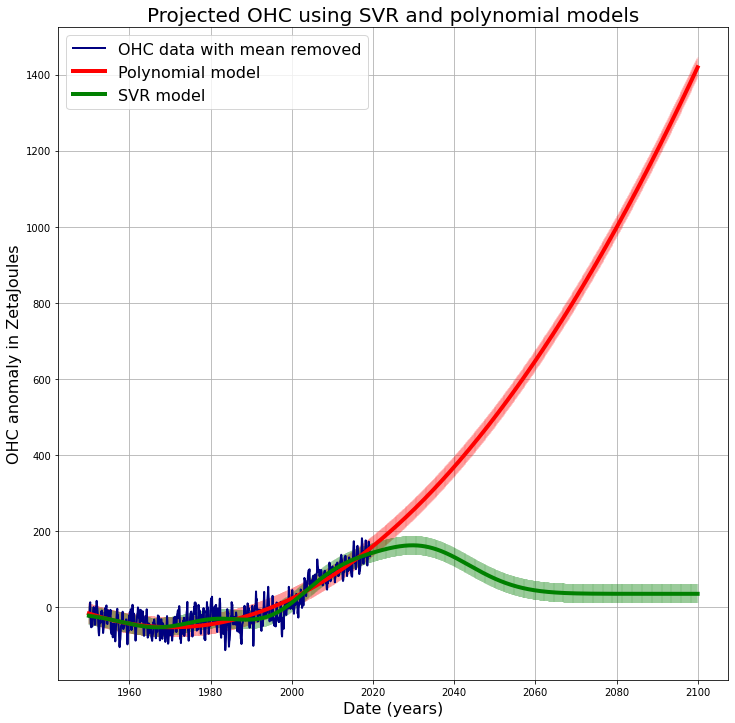

In [ ]:
plt.figure(figsize=(12,12))
plt.xlabel('Date (years)',fontsize=16)
plt.ylabel('OHC anomaly in ZetaJoules',fontsize=16)
plt.title('Projected OHC using SVR and polynomial models', fontsize=20)


plt.plot(data_date_range,df["OHC"],color='navy',linewidth=2,label='OHC data with mean removed')

plt.plot(full_date_range,f(full_df['julian_time']),color='red',linewidth=4,label='Polynomial model')
plt.errorbar(full_date_range,f(full_df['julian_time']),rmse_pol,color='red',alpha=0.1)

plt.plot(full_date_range, y_hat2,linewidth=4, color = 'green', label='SVR model')
plt.errorbar(full_date_range, y_hat2, rmse, alpha=0.1, color = 'green')

plt.grid()
plt.legend(loc='best',fontsize=16)
plt.show()

#Carte globale 

In [ ]:
#Normalisation de l'OHC
OHC700alltime =ds['ohc'].mean(dim='time')
OHC700alltimemoy = OHC700alltime.mean()
for i in range (173):
  for j in range (360):
    if OHC700alltime[i,j] == 0 : 
      
      OHC700alltime[i,j] = 'nan'

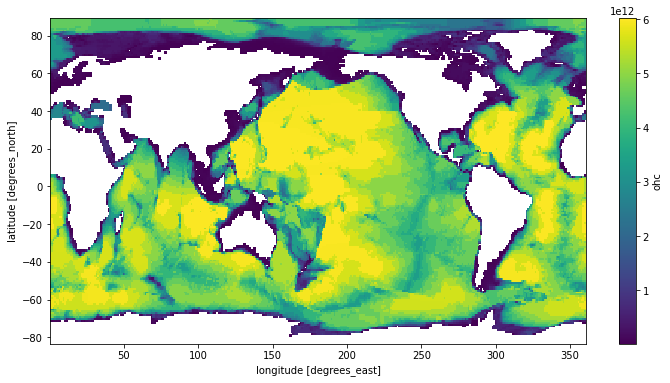

In [ ]:
OHC700alltime.plot(figsize=(12,6))

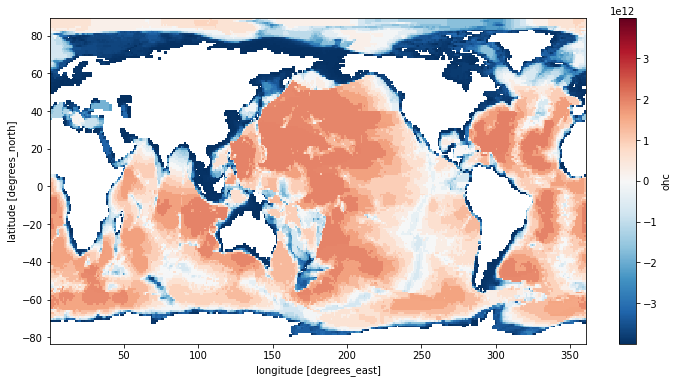

In [ ]:
OHC700alltime1  = OHC700alltime - OHC700alltimemoy
OHC700alltime1.plot(figsize=(12,6))

###Evolution en fonction de la latitude 

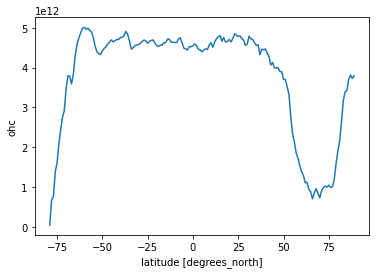

In [ ]:
ohc_lat = OHC700alltime.mean(dim='lon')
ohc_lat.plot()